## Generate Anchors using K-mean clustering

<img src="test_images/anchor_visualization.png" style="width: 600px;"/>

Anchor is a pre-defined width/height for the network to make network predict easier. Instead of directly predicting the network, our network predicts coordinate values `tx, ty, tw, th` for each cell in its output feature map. By indirectly predicting the position of bounding box relative to cell coordinates and using anchors, the network improve its numerical stabability and converge faster. 

In order to convert to bounding box, we use location of the cell `(cx, cy)`, where the center of the ground truth locates inside, and anchor `(pw, ph)` to scale the prediction as the following formula (note that everything is in relative size):
````
Transform Prediction into bounding box:
bx = sigmoid(tx) + cx
by = sigmoid(ty) + cy
bw = pw * exp(tw)
bh = ph * exp(th)
````

**K-mean Clustering**: Instead of hand-picking the anchors, we take advantage of training data to generate anchors based on the ground truth bounding boxes. This allows the network to converge faster. In this work, we selected 5 number of anchors as it is a good trade off between speed and accuracy. Having more anchors allows us to predict more accurately, however, it would also slow down the prediction speed. By plotting the `W` and `H` ratio, we might see that the width and height ratio is linearly dependent to its size.



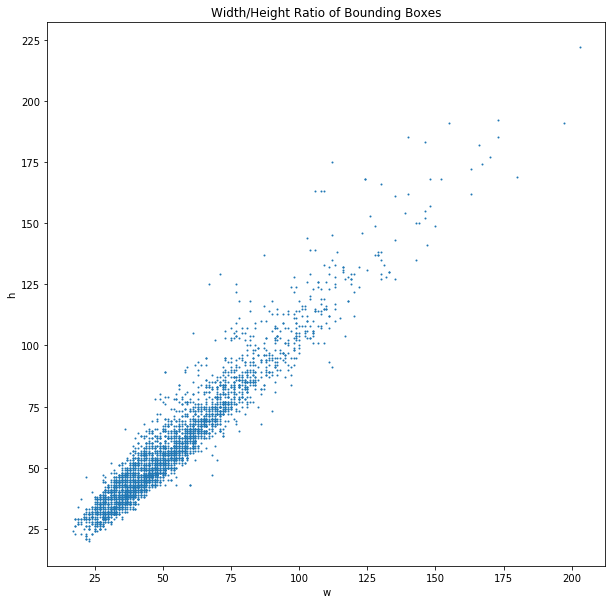

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

label_path   = 'data/training.txt'  # lisa extension training data using save_lisa_to_txt(path_to_lisa_training)
data = pd.read_csv(label_path, sep=",", header = None, names=['image','x1','y1','x2','y2','label'])
data['w'] = data['x2'] - data['x1']
data['h'] = data['y2'] - data['y1']
data[0:2]
# Visualize ratio between 'w' and 'y'
data.plot.scatter(x='w',y='h', figsize=(10,10), s=1, title='Width/Height Ratio of Bounding Boxes')

In [5]:
import numpy as np
from gen_anchors import *

k            = 5  # num_anchors
loss_conv    = 1e-5
img_size     = [1280, 960, 0]
feature_map  = [d/32 for d in img_size]    # DarkNet19 on YOLOv2 Max-pool 5 times --> output'size shrinked 2^5 = 32 times
gt_boxes = []

with open(label_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        img_path, x1, y1, x2, y2, label = line.rstrip().split(",")
        xc, yc, w, h = convert_bbox(x1, y1, x2, y2)
        xc, yc, w, h = scale_rel_box(img_size, Box(xc, yc, w, h))
        gt_boxes.append(Box(0, 0, float(w), float(h))) # since we calculate w h of anchors, we do not take xc yc into account
print("Number of ground truth boxes: {} boxes".format(len(gt_boxes)))

SyntaxError: Non-ASCII character '\xe2' in file gen_anchors.py on line 91, but no encoding declared; see http://python.org/dev/peps/pep-0263/ for details (gen_anchors.py, line 90)

In [1]:
## K-MEAN CLUSTERING
anchor_list = []
avg_iou_list = []
for k in list(range(1, 12)):
    anchors, avg_iou = k_mean_cluster(k, gt_boxes, loss_convergence=1e-6)
    print("K = {:2} | AVG_IOU:{:-4f} ".format(k, avg_iou))
    anchor_list.append(anchors)
    avg_iou_list.append(avg_iou)

NameError: name 'k_mean_cluster' is not defined

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
marker_style = dict(color='cornflowerblue', linestyle=':', marker='o',
                    markersize=15, markerfacecoloralt='gray')

x = list(range(1, 12))
plt.figure(figsize=(12, 6))
plt.plot(x, avg_iou_list, fillstyle='full', **marker_style)
plt.grid()
plt.yticks(np.arange(0, 1, 0.1))
plt.xticks(np.arange(1, 12, 1.0))
plt.xlim([1, 12] ) # this line
plt.title("Effect of Number of Anchors on Average IoU", fontsize=20)
# print result
print("Anchor [K =5] on LISA Dataset:\n")
for anchor in anchor_list[4]:  # Select K = 5 
    print(anchor.w , anchor.h)

In [ ]:
import cv2
sample_data ='test_images/stop_1405106680.avi_image9.png'

anchors = np.array(((0.023717899133663362, 0.035715759075907606),
(0.03283318210930825, 0.0483890193566751),
(0.04450034340659346, 0.064308608058608),
(0.08816276658767774, 0.1294924960505529),
(0.059577141608391594, 0.08738709207459215)))

img = cv2.cvtColor(cv2.imread(sample_data), cv2.COLOR_BGR2RGB)
height, width, c = img.shape

shrink_factor = 32
grid_w = list(range(width/shrink_factor))
grid_h = list(range(height/shrink_factor))
center = 0
# Plot grid map
for r in grid_w:
    img = cv2.line(img,(r*shrink_factor, 0), (r*shrink_factor, height), color=(0, 255, 0), thickness=2)
    
for h in grid_h:
    img = cv2.line(img,(0, h*shrink_factor), (width, h*shrink_factor), color=(0, 255, 0), thickness=2)
    
# Plot center point
for r in grid_w:
    for h in grid_h:
        centroid = ((r + 1)*shrink_factor - shrink_factor/2, (h+1)*shrink_factor - shrink_factor/2)
        img = cv2.circle(img, centroid, radius=1, color=(0, 255, 0), thickness=2)
plt.figure(figsize=(15,15))
plt.imshow(img)
plt.title('Cell Map', fontsize=20)

print("Anchors Absolute size:")
print(anchors*np.array([width, height]))
center = (1090, 420)  # of stop sign - hand picked
sample = cv2.circle(img, center, radius=2, color=(255, 255, 255), thickness=4)

for i in range(len(anchors)):
    p1 = center + anchors[i]*np.array([width, height])
    p2 = center - anchors[i]*np.array([width, height])
    result = cv2.rectangle(sample,tuple(p1.astype(int)),tuple(p2.astype(int)),(255, 255, int(255/(i+1))), thickness=2)
plt.figure(figsize=(15,15))
plt.imshow(result)
plt.title("Anchors Visualization ", fontsize=20)
result = img